# VQE and QAOA to solve MAXCUT


## 1 Some prerequisites


### 1.1 - Making sure we have qiskit installed

In [10]:
import numpy as np
from math import pi
try:
    from qiskit import *
    from qiskit_aer import AerSimulator
except:
    ! python -m pip install matplotlib pylatexenc
    ! python -m pip install qiskit qiskit-aer
    from qiskit import *
from scipy import optimize
%matplotlib inline

### 1.2 - Finding the minimum of a function in Python

I suggest to use the the operator `optimize.minimize`. Below an example of usage.


In [11]:
# The function f takes as input a list of 10 variables
def f(xs):
    res = 0
    for i in range(10):
        res = res+(xs[i]-i)*(xs[i]-i)
    return res

The function $f$ computes $\vec{x}\mapsto x_0^2+(x_1-1)^2+(x_2-2)^2+(x_3-3)^2+(x_4-4)^2...$

Its minimum is the vector $(0,1,2,3,4,5,6,7,8,9,10)$

In [12]:
# Let us infer this minimum. 
# The operator minimize takes as input the function f, a starting value as a guess, and a method.
# Powell is supposed to be well-suited for the case where we have plenty of variables...
# The manual : https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html
o = optimize.minimize(f, [1 for i in range(10)], method="Powell") 
o

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5.018264692853602e-28
       x: [ 1.443e-15  1.000e+00  2.000e+00  3.000e+00  4.000e+00
            5.000e+00  6.000e+00  7.000e+00  8.000e+00  9.000e+00]
     nit: 3
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 254

In [13]:
# The inferred minimum vector is stored at the key `x`:
list(o.x)

[np.float64(1.4432899320127035e-15),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(2.9999999999999987),
 np.float64(3.9999999999999916),
 np.float64(5.000000000000003),
 np.float64(5.999999999999991),
 np.float64(6.9999999999999964),
 np.float64(7.9999999999999964),
 np.float64(9.000000000000018)]

### 1.3 - BEWARE

We shall heavily rely on the backend `qasm_simulator`, which returns a dictionary of the form 

`{result1: nber_of_draw, result2: nber_of_draw, ...}`

The results are strings of `0` and `1`. For instance, if one measure a Bell state one can expect the result `{"00" : 500, "11": 500}` if we asked for 1000 runs.

However, one has to remember that the string is in the "wrong" order: the last bit corresponds to the first qubit.
For instance, here is what I mean:

In [14]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

# Applying X on qubit 0
qc.x(q[0])

# So at the end the state is |10>
qc.measure(q,c)

qc.draw()

# But then, the register c[0] holds 1 and c[1] holds 0, as shown here:
simulator = AerSimulator()
job = simulator.run(qc.decompose(reps=6), shots=1024)
res = dict(job.result().get_counts(qc))
res

{'01': 1024}

We have $b_1b_0$ instead of $b_0b_1$ ... Do not forget this side-effect !

## 2 - Coding graphs

In this lab session, we code graphs as follows:
 - nodes are numbers `0,1,2,3...`
 - edges are stored with dictionary: to a node one associates a set of its neighbourgs.

The graphs are non-directed: we take as convention that if `g` is a graph and if $j \in g[i]$, then $i<j$.

Some examples are as follows.

In [15]:
g1 = {0: set([1,2]), 1:set([2,3]), 2:set([3])}
g2 = {0: set([1,2,3])}
g3 = {0: set([1]), 1: set([2]), 2: set([3])}

### 2.1 - Cuts in a graph

for a graph with nodes $0,1,2,3,...n$, a **cut** is written as a string $b_n...b_2b_1b_0$ with $b_i$ characters `0` or `1`. The node $i$ belongs to the set $V_{b_i}$. For instance, `1010` corresponds to the two sets $V_0=\{0,2\}$ and $V_1=\{1,3\}$.

Note how we read the nodes backward in the string: this is due to the way the measure is handled in Qiskit.

Given a cut `s` for a graph `g`, the **cost** of the cut is the number of edges crossing it.

#### TODO Implement the function computing the cost of a cut

In [7]:
def costOfCut(g,s): # g is a graph, s is a cut
    r = 0
    
    # TODO : UPDATE r
    
    return r

In [8]:
# Tests

print(costOfCut(g1,"0110")) # Should be 4
print(costOfCut(g2,"0111")) # Should be 1
print(costOfCut(g2,"1110")) # Should be 3

0
0
0


### 2.2 - Scalar product

In both VQE and QAOA, we are interested in finding the eigenvector of minimum eigenvalue for the Hamiltonian
$$
H_C = -\sum_x C(x)|x\rangle\langle x|
$$
where $C$ is the cost function `costOfCut` for the graph.

For this, we discussed how it is sufficient to look for the vector $|\phi\rangle$ minimizing
$$
|\phi\rangle \mapsto \langle \phi|H_C|\phi\rangle
$$

We also discussed how to estimate $\langle \phi|H_C|\phi\rangle$ from a probabilistic distribution of measurements of $|\phi\rangle$.


#### TODO Implement the scalar product

The input `d` is assumed to be the probabilistic distribution corresponding to the result of a measurement, for instance `d` could be

   `{ "00" : 0.5, "11" : 0.5" }`
   
if it were the result of measuring a Bell state. 

Recall that we are in the case where the Hamiltonian is diagonal, so the computation is very simple. Remember also that we are looking to MAXIMIZE a value but that VQE will perform a minimization...

In [9]:
def scalprod(g,d):
    r = 0
    
    # TODO : COMPUTE r
    
    return -r  # I added the minus sign for you...

## 2 - MAXCUT with VQE

We need to be able to build parameterized gates. As discussed in the course, a general gate on one qubit can always be written using 3 angles. In QisKit, this is the gate  `u`. Here is a small self-contained example of building  circuit with this gate, and running the circuit

In [10]:
# A very simple circuit
q = QuantumRegister(1, name="q")
qc = QuantumCircuit(q)

# To apply a generic gate on qubit 0:
angle1 = 1.23
angle2 = 2.34
angle3 = 4.56
qc.u(angle1,angle2,angle3,q[0])

# see in particular
# https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html#u-gates

qc.draw()

┌───────────────────┐
q: ┤ U(1.23,2.34,4.56) ├
   └───────────────────┘

### 2.1 - The problem

We shall be coding VQE for the Hamiltonian steaming from MAXCUT, exactly the way we saw it on the board. As discussed, the objective is to find the maximal cut of the graph `g1`, drawn as below:

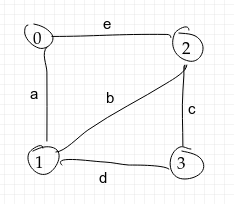




The problem can be splitted in two parts : 
* Generate a probability distribution
* Infer the scalar product out of this distribution

### 2.2 - Implementation

We already have the function for computing the scalar product: remains generating the probabilistic distribution, as with the circuit we saw in class.

#### TODO fill in the following function

It inputs a list of angles to be used to make columns of CNOTS and u gates. The u-gates rotates the state while the CNOTs are there to create some entanglement. The way the CNOTs are placed is not very important, as long as all wires are connected. For instance, we can use the following circuit:

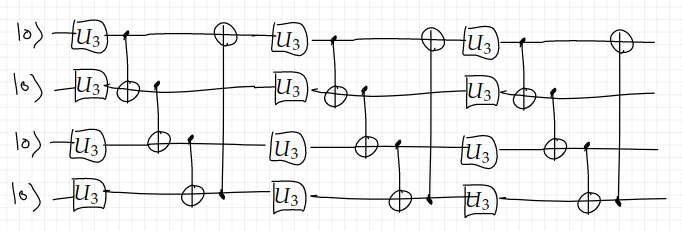

with a measurement at the end. Each $U_3$ is the generic u-gate defined with 3 angles, so each tower of U's requires 12 angles. A series of 3 layers, as displayed above, therefore needs an array of 36 angles. One can use more, or less layers: the goal is to be able to attain as much states as possible.

**Note** This is an *example of ansatz*, a "circuit with holes". It is not necessarily the only one, nor the best one. And in fact, the QAOA proposes another ansatz, more suitable.


We then want to return an estimate of the probabilistic distribution steaming from the measurement of the memory.

In [11]:
def probDistVQE(a): # The variable a contains a list of angles (real numbers).
    q = QuantumRegister(4)
    c = ClassicalRegister(4)
    qc = QuantumCircuit(q,c)
    
    
    
    # TODO : circuit for VQE
    
    

    # At this stage, the circuit should have "computed" the candidate vector |phi> needed 
    # for the computation <phi|Hamiltonien|phi>. We cannot do this here, but we can measure and 
    # do it offline, with the probability distribution.
    
    # We then add a measure at the end
    qc.measure(q, c)
    
    # We set up a backend
    backend = BasicAer.get_backend('qasm_simulator')
    
    # 1000 runs on the backend
    job = execute(qc, backend, shots=1000)

    # Collect the results
    res = dict(job.result().get_counts(qc))
    
    # Renormalize so that the gradients are not awfull
    for i in res:
        res[i] = res[i] / 1000
    
    # Return the final distribution
    return res

The function `probDistVQE` is the one we want to minimize. It is enough to call `optimize.minimize`. As input table, we can take whatever we want (`[0.0, 0,0,.... 0.0]` for instance).

Then, if `o` contains the answer to the call to `optimize.minimize`:
* `list(o.x)` is a table of angles which answers the problem
* It is enough to give it as argument to `probDistVQE` to get the distribution maximizing the probability of the "*good cuts*".

**BEWARE** the variable `initAngles` should only contains floats, not integers...

In [12]:
# The graph
g = g1

# The function to minimize
def toMinimizeVQE(a):
    return scalprod(g,probDistVQE(a))

# Initial guess for the angle
initAngles=[0.0 for i in range(12*3)]

# Let us minimize it
o = optimize.minimize(toMinimizeVQE, initAngles, method="Powell") 

# Let us retrieve the probability distribution
probDistVQE(list(o.x))

# Slowww but normal

{'0000': 1.0}

### 2.3 - Questions and discussion

* What are the various proposed cuts $(V_{0},V_{1})$ ?

* Change the graph and check that it does not work "just by chance" (for instance, use `g2`, `g3`, or your own).

*  Are all possible cuts there ?

* The problem is symmetric, in the sense that if '0110' is an answer, so is '1001'. Is this reflected in the resulting probabilities ?

* If we had access to a real quantum co-processor, how would the code change ?